<a href="https://colab.research.google.com/github/rmahesh6386/DataScience_Python/blob/main/Forecasting_Model_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive


In [2]:
# For reading stock data from yahoo
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

# For time stamps
from datetime import datetime

# For division
from __future__ import division

In [3]:
#stock Company for analytics
stock = ['TATAMOTORS.NS']
data_source = 'yahoo' 

# set up Start and End time for data grab
end = datetime.now()
start = datetime(end.year-10,end.month,end.day)

# Set DataFrame as the Stock Ticker
TM = pdr.get_data_yahoo(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#series = read_csv('water.csv', header=0, index_col=0, parse_dates=True)

In [6]:
series = TM['Close']

In [7]:
series

Date
2012-07-19    222.414383
2012-07-20    221.029236
2012-07-23    213.757233
2012-07-24    213.559357
2012-07-25    210.739609
                 ...    
2022-07-13    427.100006
2022-07-14    428.049988
2022-07-15    440.200012
2022-07-18    450.899994
2022-07-19    449.049988
Name: Close, Length: 2464, dtype: float64

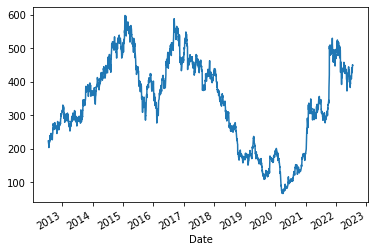

In [8]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
series.plot()
pyplot.show()

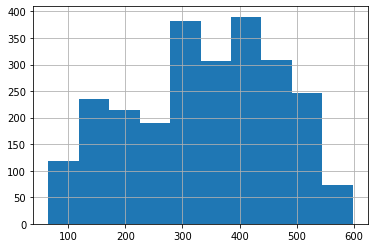

In [9]:
series.hist()

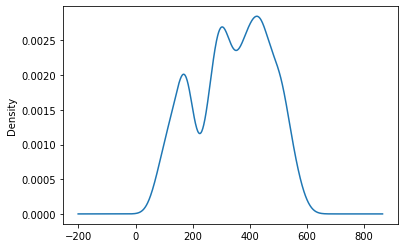

In [10]:
series.plot(kind='kde')

In [11]:
# separate out a validation dataset
split_point = len(series) - 500
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 1964, Validation 500


#### Persistence/ Base model

In [12]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]


In [13]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=493.900, Expected=491.050
>Predicted=491.050, Expected=507.200
>Predicted=507.200, Expected=509.000
>Predicted=509.000, Expected=503.250
>Predicted=503.250, Expected=510.100
>Predicted=510.100, Expected=506.850
>Predicted=506.850, Expected=503.200
>Predicted=503.200, Expected=508.250
>Predicted=508.250, Expected=493.300
>Predicted=493.300, Expected=478.400
>Predicted=478.400, Expected=500.000
>Predicted=500.000, Expected=516.400
>Predicted=516.400, Expected=514.800
>Predicted=514.800, Expected=513.800
>Predicted=513.800, Expected=503.450
>Predicted=503.450, Expected=503.250
>Predicted=503.250, Expected=516.800
>Predicted=516.800, Expected=507.600
>Predicted=507.600, Expected=510.400
>Predicted=510.400, Expected=512.050
>Predicted=512.050, Expected=510.000
>Predicted=510.000, Expected=503.950
>Predicted=503.950, Expected=504.000
>Predicted=504.000, Expected=498.350
>Predicted=498.350, Expected=493.850
>Predicted=493.850, Expected=503.750
>Predicted=503.750, Expected=525.300
>

#### ARIMA Hyperparameters

In [14]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

#### Grid search for p,d,q values

In [15]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [16]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
#evaluate parameters
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
#evaluate_models(train.values, p_values, d_values, q_values)

#### Build Model based on the optimized values

In [17]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [18]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

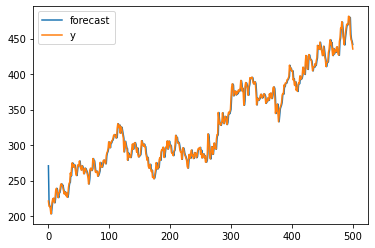

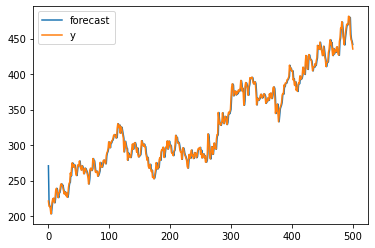

In [36]:
# fit model
model = ARIMA(X, order=(1,0,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=500)[0]
model_fit.plot_predict(0,500)

In [37]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

198.54898331733577

In [35]:
forecast

array([106.65544199, 106.91048549, 107.16513262, 107.41938402,
       107.67324028, 107.92670203, 108.17976988, 108.43244445,
       108.68472633, 108.93661615, 109.18811451, 109.43922203,
       109.6899393 , 109.94026693, 110.19020554, 110.43975572,
       110.68891808, 110.93769322, 111.18608174, 111.43408425,
       111.68170134, 111.92893362, 112.17578167, 112.4222461 ,
       112.66832751, 112.91402649, 113.15934363, 113.40427952,
       113.64883477, 113.89300996, 114.13680568, 114.38022252,
       114.62326107, 114.86592192, 115.10820565, 115.35011286,
       115.59164412, 115.83280002, 116.07358115, 116.31398808,
       116.5540214 , 116.79368169, 117.03296953, 117.27188549,
       117.51043016, 117.74860411, 117.98640792, 118.22384216,
       118.46090742, 118.69760425, 118.93393323, 119.16989494,
       119.40548995, 119.64071882, 119.87558213, 120.11008044,
       120.34421432, 120.57798434, 120.81139106, 121.04443505,
       121.27711687, 121.50943708, 121.74139625, 121.97

In [31]:
val

,0,1
0,2020-07-20,105.050003
1,2020-07-21,108.449997
2,2020-07-22,105.150002
3,2020-07-23,106.050003
4,2020-07-24,103.750000
...,...,...
495,2022-07-13,427.100006
496,2022-07-14,428.049988
497,2022-07-15,440.200012
498,2022-07-18,450.899994


#### Combine train and test data and build final model

In [21]:
# fit model
data = series
# prepare data
X = train.values
X = X.astype('float32')

In [22]:
model = ARIMA(X, order=(1,0,0))
model_fit = model.fit()

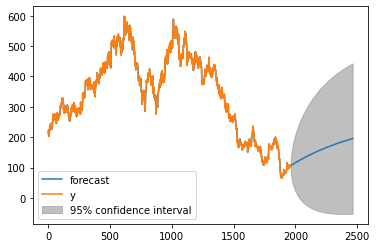

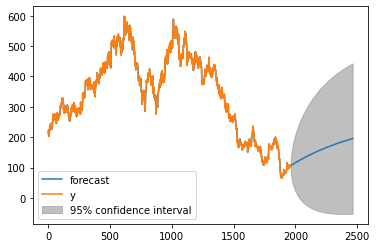

In [23]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,2464)

In [24]:
forecast

array([106.65544199, 106.91048549, 107.16513262, 107.41938402,
       107.67324028, 107.92670203, 108.17976988, 108.43244445,
       108.68472633, 108.93661615])